In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import glob

mpl.rcParams['figure.figsize'] = (5,5)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

In [26]:
model_dir = "../models/v8_shrinkwindows/"
model_name = "v8_shrinkwindows"
model_version = 7
cols = ["seed_eta", "seed_phi", "seed_iz","en_seed","et_seed",
        "cluster_deta", "cluster_dphi", "en_cluster", "et_cluster",
       "seed_f5_r9", "seed_f5_sigmaIetaIeta","seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi","seed_swissCross","seed_nxtals",
        "cl_f5_r9", "cl_f5_sigmaIetaIeta","cl_f5_sigmaIetaIphi","cl_f5_sigmaIphiIphi","cl_swissCross", "cl_nxtals"]
os.makedirs(model_dir, exist_ok = True)
with open("variables.txt", "w") as of:
    of.write("\n".join(cols))

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- delta_eta,delta_phi,

Filter only windows with the calo

In [3]:
files_ele = "/storage/ECAL/training_data/electrons/numpy_v10/training/"
files_gamma = "/storage/ECAL/training_data/gammas/numpy_v10/training/"

In [4]:
files_ele = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/electrons/numpy_v9/training/"
files_gamma = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/gammas/numpy_v9/training/"

In [4]:
datas_ele = []

for f in glob.glob(files_ele+"*.pkl"):
    d = pickle.load(open(f, "rb"))   
    datas_ele.append(d[d.is_seed == False])
    
data_ele = pd.concat(datas_ele, ignore_index=True)
data_ele["particle"] = "electron"
print("N events ele: ",len(data_ele))

datas_gamma = []
for f in glob.glob(files_gamma+"*.pkl"):
    d = pickle.load(open(f, "rb"))  
    datas_gamma.append(d[d.is_seed==False])
    
data_gamma = pd.concat(datas_gamma, ignore_index=True)
data_gamma["particle"] = "gamma"
print("N events gamma: ",len(data_gamma))

if data_ele.shape[0]> data_gamma.shape[0]:
    data = pd.concat([data_gamma, data_ele.iloc[0:len(data_gamma)]], ignore_index=True)
else:
    data = pd.concat([data_gamma.iloc[0:len(data_ele)], data_ele], ignore_index=True)
    
del data_gamma
del data_ele

N events ele:  11592214
N events gamma:  11010475


Balance gamma and electron

In [5]:
data_EB = data[abs(data.seed_eta)<1.479]
data_EE = data[abs(data.seed_eta)>=1.479]

In [6]:
print("Sample in EB:", len(data[abs(data.seed_eta) <1.479]))
print("Sample in EE:", len(data[abs(data.seed_eta) >=1.479]))
print("Sample in EB in SC:", len(data[(abs(data.seed_eta) <1.479)&(data.in_scluster)]))
print("Sample in EE in SC:", len(data[(abs(data.seed_eta) >=1.479)&(data.in_scluster)]))
print("N in supercluster: ", len(data[ data.in_scluster]))
print("N out supercluster: ", len(data[data.in_scluster == False]))
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print(w)

Sample in EB: 14606044
Sample in EE: 7414906
Sample in EB in SC: 1222260
Sample in EE in SC: 675211
N in supercluster:  1897471
N out supercluster:  20123479
10.605421110520266


In [7]:
print("caloMatch samples: ", len(data[data.is_calo_matched]))
print("Not caloMatch samples: ", len(data[data.is_calo_matched ==False]))

caloMatch samples:  12749438
Not caloMatch samples:  3114636


## Check plots

In [9]:
data_in = data[ (data.is_seed == False) & data.in_scluster]
data_out =  data[(data.is_seed == False) & (data.in_scluster == False)]

## Weights by DeltaPhi

In [7]:
data = data_EE

In [46]:
inSC = len(data[(data.is_seed == False) & (data.in_scluster == True)])
data = pd.concat([data[(data.is_seed == False) & (data.in_scluster == True)],
                  data[(data.is_seed == False) & (data.in_scluster == False)].iloc[:25*inSC]])

In [8]:
X = data[ cols ].values
truth = data[["in_scluster"]].values
y = np.array(truth[:], dtype=int)
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print(w)
data["w"] = data.in_scluster.apply(lambda a: w if a else 1.)
weight = data.w.values

9.981613154998955


In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(model_dir + "/scaler_model_v{}_EB.pkl".format(model_version), "wb"))

In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(model_dir+"/scaler_model_v{}_EE.pkl".format(model_version), "wb"))

In [68]:
scaler.mean_

array([-9.48937722e-02, -2.59092069e-02, -3.23802034e-02,  8.54387012e+01,
        1.95493967e+01, -7.99008024e-03,  1.68780274e-05,  8.92748605e+00,
        1.92283524e+00,  1.08804190e+00,  3.39450646e-02,  1.85485538e-05,
        4.13554904e-02,  4.96716655e-01,  5.44590774e+00,  4.09401210e+00,
        3.71462585e-02,  4.80538918e-05,  4.39461957e-02,  5.70297494e-01,
        3.15806715e+00])

In [69]:
scaler.scale_

array([2.27502784e+00, 1.80358311e+00, 9.99475624e-01, 1.25874656e+02,
       2.62122915e+01, 1.01794340e-01, 1.81101293e-01, 6.05398279e+00,
       1.77231292e+00, 5.03589571e-01, 1.40048073e-02, 4.14562658e-04,
       1.53689902e-02, 4.13270103e-01, 5.68762983e+00, 9.93354108e+00,
       1.65018741e-02, 5.45041026e-04, 1.80243836e-02, 4.37347302e-01,
       4.28826919e+00])

In [22]:
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_scaled, y, weight, test_size=0.20)

### Some plots

(array([ 963945., 1267364.,  389801.,  171804.,  109812.,   87864.,
          76999.,   72278.,   68661.,   65882.,   63736.,   62730.,
          62554.,   61238.,   60421.,   58754.,   59162.,   59712.,
          59007.,   59189.,   57734.,   57981.,   57890.,   57737.,
          56137.,   57025.,   56327.,   56149.,   56198.,   56203.,
          55680.,   55389.,   56108.,   55327.,   55027.,   53745.,
          53287.,   54051.,   52813.,   52210.,   50603.,   50097.,
          47282.,   45609.,   41465.,   36861.,   30424.,   22149.,
          13623.,    6616.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <a list of 50 Patch objects>)

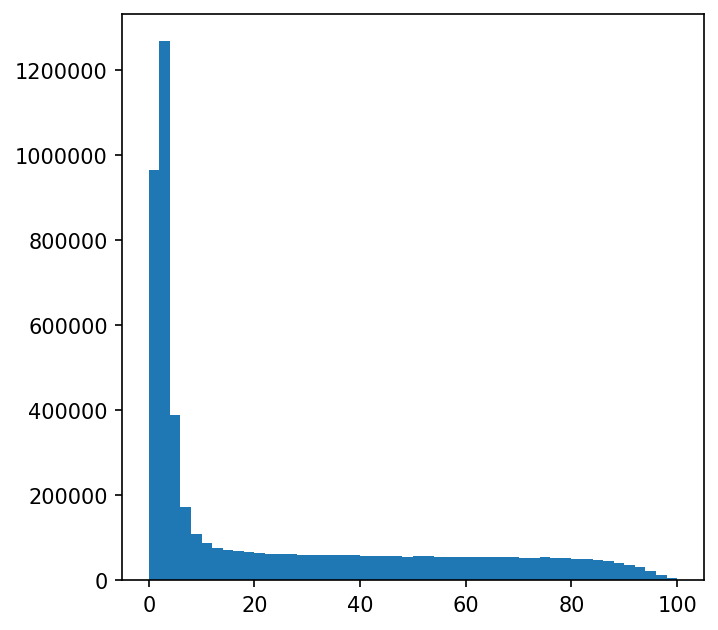

In [13]:
plt.hist(data.et_seed, bins=50, range=(0,100))

### Balancing the et regions

In [14]:
small_et = data[data.et_seed < 20].w.sum()
big_et = data[data.et_seed > 20].w.sum()

In [15]:
print(small_et)
print(big_et)

4857537.93325426
4854140.066745742


# Training

In [11]:
# Import all the required Libraries
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import callbacks
from keras import backend as K
from keras import regularizers
from keras.callbacks import *

Using TensorFlow backend.


In [28]:
model = Sequential()
model.add(Dense(100, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 100)               2200      
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_22 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 100)              

In [31]:
model = Sequential()
model.add(Dense(100, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 100)               2200      
_________________________________________________________________
dropout_24 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_25 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_26 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)              

In [13]:
import math
def step_decay(epoch):
    initial_lrate = 0.4
    drop = 0.65
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if lrate < 0.002: return 0.002
    return lrate

In [18]:
auto_save = ModelCheckpoint(model_dir+ "/model_v{}_EB.hd5".format(model_version), monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=2)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=10, verbose=1)


#lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

history = model.fit(
            X_train, y_train,
            sample_weight = w_train,
            batch_size = 4096,
            epochs=400,
            shuffle=True,
            validation_data = (X_val, y_val, w_val),
            callbacks = [early_stop, auto_save] #lr_scheduler
            )

Train on 4273837 samples, validate on 1068460 samples
Epoch 1/400
 770048/4273837 [====>.........................] - ETA: 17s - loss: 0.6904 - accuracy: 0.9133

KeyboardInterrupt: 

In [32]:
auto_save = ModelCheckpoint(model_dir+ "/model_v{}_EE.hd5".format(model_version) , monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=2)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=10, verbose=1)


lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

history = model.fit(
            X_train, y_train,
            sample_weight = w_train,
            batch_size = 2048,
            epochs=400,
            shuffle=True,
            validation_data = (X_val, y_val, w_val),
            callbacks = [early_stop, auto_save] #lr_scheduler
            )

Train on 5931924 samples, validate on 1482982 samples
Epoch 1/400
5931924/5931924 [==============================] - 39s 7us/step - loss: 0.3534 - accuracy: 0.9362 - val_loss: 0.2879 - val_accuracy: 0.9198
Epoch 2/400
5931924/5931924 [==============================] - 39s 7us/step - loss: 0.2745 - accuracy: 0.9445 - val_loss: 0.2612 - val_accuracy: 0.9518

Epoch 00002: val_loss improved from inf to 0.26123, saving model to ../models/v8_shrinkwindows//model_v7_EE.hd5
Epoch 3/400
5931924/5931924 [==============================] - 39s 7us/step - loss: 0.2645 - accuracy: 0.9460 - val_loss: 0.2534 - val_accuracy: 0.9516
Epoch 4/400
5931924/5931924 [==============================] - 39s 7us/step - loss: 0.2593 - accuracy: 0.9468 - val_loss: 0.2521 - val_accuracy: 0.9584

Epoch 00004: val_loss improved from 0.26123 to 0.25213, saving model to ../models/v8_shrinkwindows//model_v7_EE.hd5
Epoch 5/400
5931924/5931924 [==============================] - 39s 7us/step - loss: 0.2559 - accuracy: 0.947

5931924/5931924 [==============================] - 39s 7us/step - loss: 0.2347 - accuracy: 0.9501 - val_loss: 0.2284 - val_accuracy: 0.9544
Epoch 42/400
5931924/5931924 [==============================] - 39s 7us/step - loss: 0.2346 - accuracy: 0.9502 - val_loss: 0.2280 - val_accuracy: 0.9511

Epoch 00042: val_loss did not improve from 0.22658
Epoch 43/400
5931924/5931924 [==============================] - 39s 7us/step - loss: 0.2346 - accuracy: 0.9502 - val_loss: 0.2288 - val_accuracy: 0.9479
Epoch 44/400
5931924/5931924 [==============================] - 39s 7us/step - loss: 0.2345 - accuracy: 0.9502 - val_loss: 0.2300 - val_accuracy: 0.9429

Epoch 00044: val_loss did not improve from 0.22658
Epoch 45/400
5931924/5931924 [==============================] - 39s 7us/step - loss: 0.2341 - accuracy: 0.9501 - val_loss: 0.2272 - val_accuracy: 0.9523
Epoch 46/400
5931924/5931924 [==============================] - 39s 7us/step - loss: 0.2339 - accuracy: 0.9503 - val_loss: 0.2272 - val_accuracy

>>> Computing AUC...
AUC score: 0.99111190515057
>>> Saving ROC curve...


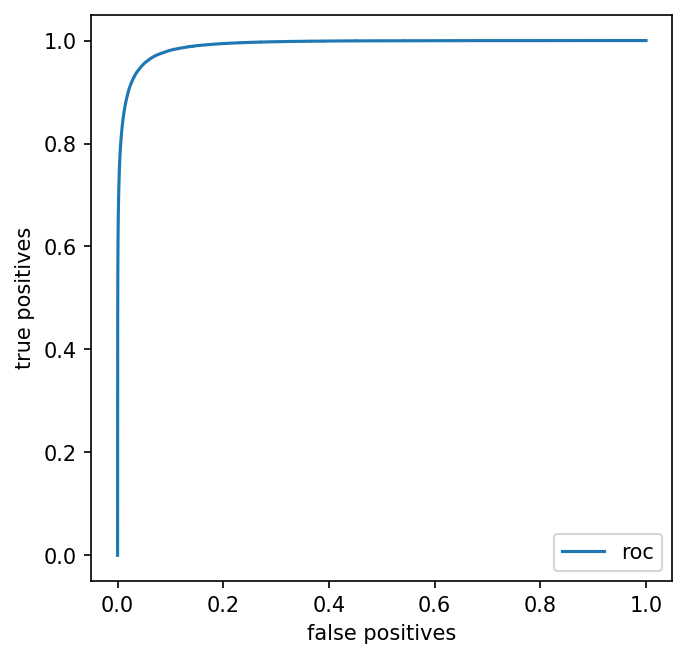

In [33]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_val,batch_size=2048)
auc = roc_auc_score(y_val, pred, sample_weight=w_val)
print("AUC score: " + str(auc))

print(">>> Saving ROC curve...")
fp , tp, th = roc_curve(y_val, pred, sample_weight=w_val,drop_intermediate=True)
plt.plot(fp, tp, label="roc")
#plt.plot(fp, th, label="threshold")
plt.xlabel("false positives")
plt.ylabel("true positives")
plt.ylim(-0.05,1.05)

plt.legend()

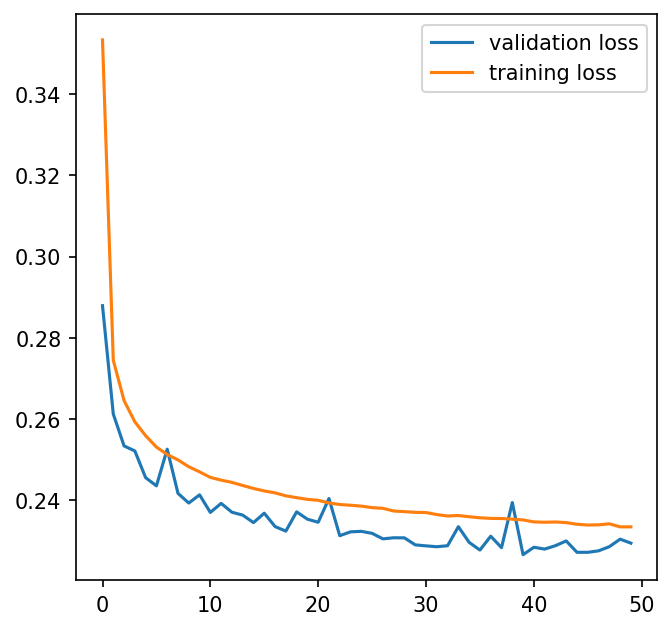

In [34]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

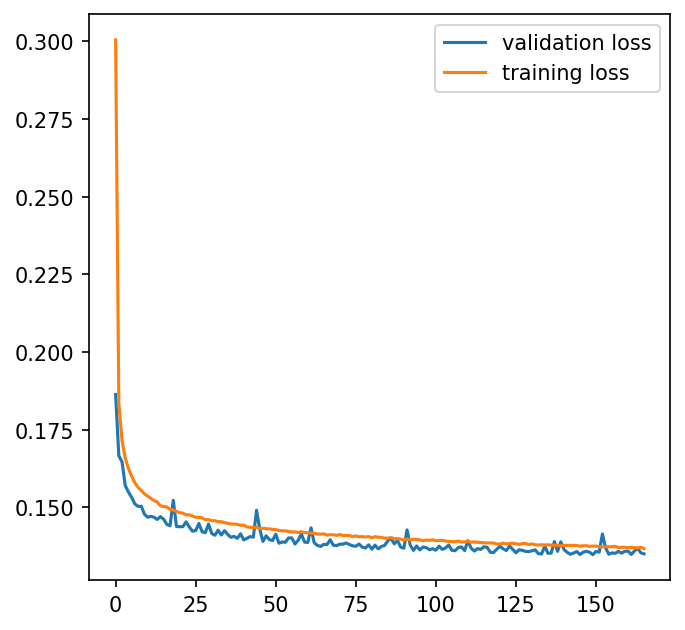

In [64]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

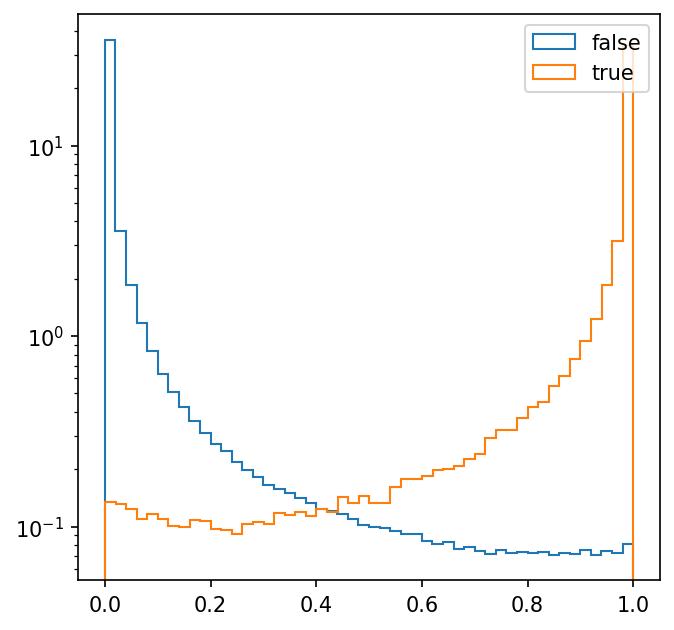

In [35]:
results = model.predict(X_val)
plt.hist(results[y_val==0], bins=50,density=True, label="false", histtype="step")
plt.hist(results[y_val==1], bins=50, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

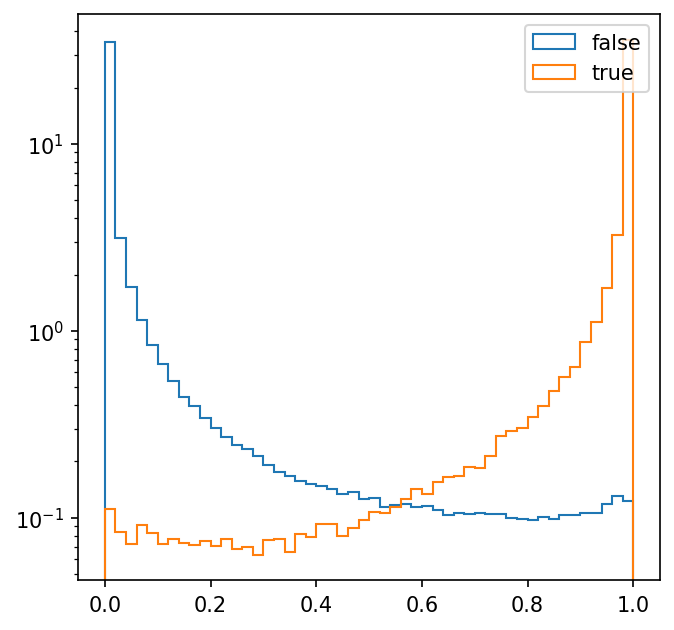

In [22]:
results = model.predict(X_val)
plt.hist(results[y_val==0], bins=50,density=True, label="false", histtype="step")
plt.hist(results[y_val==1], bins=50, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

In [34]:
plt.savefig(model_dir +"/output_model_v1_EB.png")

<Figure size 750x750 with 0 Axes>

# Some plots

In [1]:
from keras.models import load_model
model = load_model("models/model11_balanced_100_80_50.hd5")
scaler = pickle.load(open("models/scaler_gamma_electrons.pkl", "rb"))

Using TensorFlow backend.


OSError: Unable to open file (unable to open file: name = 'models/model11_balanced_100_80_50.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [27]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()

NameError: name 'y_test' is not defined

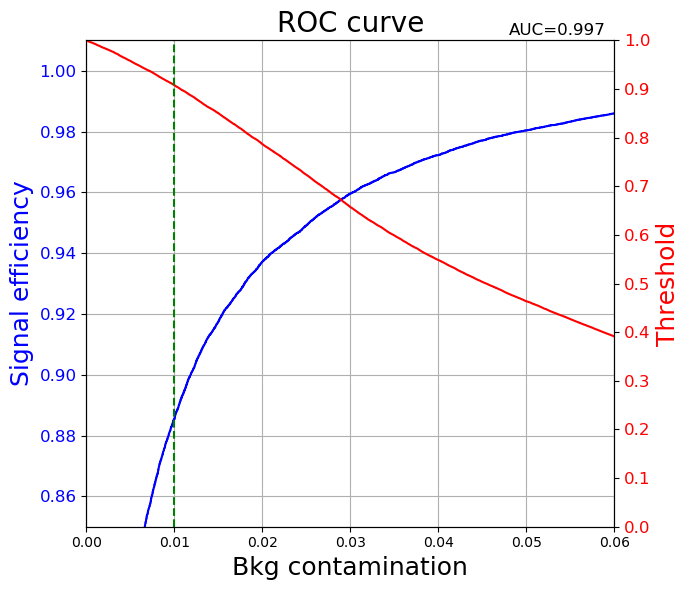

In [36]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()